# Data Normalization and Correlation Analysis
## Group Project - Step 3

**Objectives:**
1. Normalize all variables using z-score or min-max scaling (with justification)
2. Analyze correlations among fundamental frequency, Jitter, and Shimmer variables
3. Keep representative variables and remove redundant ones

**Inputs:** Cleaned DataFrame  
**Outputs:** Normalized DataFrame, cleaned_df

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## 1. Load the Dataset
First, we load the cleaned dataframe from the previous step, as asked as the input for this task. 

In [24]:
# Load the dataset
df = pd.read_csv('../data/02_cleaned/coronary_disease_clean.csv')

# Display basic information
print("Dataset Shape:", df.shape)

display(df.head())

Dataset Shape: (4218, 15)


,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## 2. Data Preparation
Here we identify numeric columns and separate features for normalization

In [25]:
# Get all column names
all_columns = df.columns.tolist()

# Identify numeric columns##
all_numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Identify non-numeric columns (categorical like 'sex', 'education' if string)
non_numeric_categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Separate numeric columns into binary categorical vs continuous
binary_categorical_cols = []
continuous_numeric_cols = []

for col in all_numeric_cols:
    unique_vals = df[col].dropna().unique()
    # Check if variable only contains 0 and 1 (binary categorical)
    if set(unique_vals).issubset({0, 1, 0.0, 1.0}):
        binary_categorical_cols.append(col)
    else:
        continuous_numeric_cols.append(col)

# Store continuous numeric for normalization
numeric_cols = continuous_numeric_cols

# Store ALL categorical variables (both non-numeric and binary numeric)
all_categorical_cols = non_numeric_categorical_cols + binary_categorical_cols

print("VARIABLE CLASSIFICATION")

print(f"\n TOTAL COLUMNS: {len(all_columns)}")

print(f"\n CONTINUOUS NUMERIC (Will be normalized): {len(continuous_numeric_cols)}")
for i, col in enumerate(continuous_numeric_cols, 1):
    sample_vals = df[col].dropna().head(3).tolist()
    print(f"   {i}. {col:20s} (e.g., {sample_vals})")

print(f"\n BINARY CATEGORICAL (Keep as 0/1, not normalized): {len(binary_categorical_cols)}")
for i, col in enumerate(binary_categorical_cols, 1):
    print(f"   {i}. {col:20s} (0=No, 1=Yes)")

print(f"\n NON-NUMERIC CATEGORICAL (Keep as-is, not normalized): {len(non_numeric_categorical_cols)}")
if len(non_numeric_categorical_cols) > 0:
    for i, col in enumerate(non_numeric_categorical_cols, 1):
        unique_vals = df[col].unique()[:3]
        print(f"   {i}. {col:20s} (e.g., {unique_vals})")
else:
    print("   None found")


VARIABLE CLASSIFICATION

 TOTAL COLUMNS: 15

 CONTINUOUS NUMERIC (Will be normalized): 8
   1. age                  (e.g., [39, 46, 48])
   2. cigsPerDay           (e.g., [0.0, 0.0, 20.0])
   3. totChol              (e.g., [195.0, 250.0, 245.0])
   4. sysBP                (e.g., [106.0, 121.0, 127.5])
   5. diaBP                (e.g., [70.0, 81.0, 80.0])
   6. BMI                  (e.g., [26.97, 28.73, 25.34])
   7. heartRate            (e.g., [80.0, 95.0, 75.0])
   8. glucose              (e.g., [77.0, 76.0, 70.0])

 BINARY CATEGORICAL (Keep as 0/1, not normalized): 7
   1. sex                  (0=No, 1=Yes)
   2. currentSmoker        (0=No, 1=Yes)
   3. BPMeds               (0=No, 1=Yes)
   4. prevalentStroke      (0=No, 1=Yes)
   5. prevalentHyp         (0=No, 1=Yes)
   6. diabetes             (0=No, 1=Yes)
   7. TenYearCHD           (0=No, 1=Yes)

 NON-NUMERIC CATEGORICAL (Keep as-is, not normalized): 0
   None found


## 3. Check Data Distribution
Then we want to analyze distributions to justify the normalization method choice

In [26]:
# Statistical summary of numeric variables
print("Statistical Summary:")
display(df[numeric_cols].describe())

# Check for outliers using IQR method
print("\nOutlier Detection (IQR Method):")
outlier_summary = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_summary[col] = len(outliers)

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_df['Outlier %'] = (outlier_df['Outlier Count'] / len(df) * 100).round(2)
display(outlier_df.sort_values('Outlier Count', ascending=False).head(10))

Statistical Summary:


,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000
mean,49.572309,9.091275,236.747511,132.325154,82.905880,25.801181,75.877904,81.623518
std,8.556892,11.923098,44.340952,21.964470,11.905447,4.080241,12.030829,22.731569
min,32.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000
25%,42.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,72.000000
50%,49.000000,0.000000,234.000000,128.000000,82.000000,25.395000,75.000000,78.000000
75%,56.000000,20.000000,262.750000,143.875000,89.500000,28.040000,83.000000,85.000000
max,70.000000,70.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000



Outlier Detection (IQR Method):


,Outlier Count,Outlier %
glucose,264,6.26
sysBP,126,2.99
BMI,97,2.30
diaBP,87,2.06
heartRate,76,1.80
totChol,55,1.30
cigsPerDay,12,0.28
age,0,0.00


## 4. Normalization Method Selection

### Justification:

Based on the outlier analysis done above, we decided that will use **Min-Max Scaling** because:
- Most variables have low outlier percentages (< 5%), making the method viable
- Several variables are binary (BPMeds, prevalentStroke, prevalentHyp, diabetes), which naturally fit the [0,1] range
- Medical measurements have meaningful bounded ranges that the Min-Max method preserves well
- Given that in following steps we want to use deep learning and trained models, the results from this method are better suited fo the subsequent analysis
- The [0,1] range makes feature importance more interpretable in medical contexts
- We can't assume Normal Distribution for this variables, and therefore would be hard to use z-score normalization

In [27]:
# Create a copy of the dataframe to preserve original data
df_normalized = df.copy()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization ONLY to continuous numeric columns
# All categorical columns (both binary and non-numeric) remain unchanged
df_normalized[numeric_cols] = scaler.fit_transform(df[numeric_cols])

## 5. Correlation Analysis
### First we identify meaningful variable groups for the correlation analysis

Since this is cardiovascular disease data, we'll analyze correlations within
physiologically related variable groups:

In [28]:
# We define these variable groups based on physiological relationships
variable_groups = {
    'Blood Pressure': {
        'variables': ['sysBP', 'diaBP']
    },
    'Metabolic': {
        'variables': ['totChol', 'glucose', 'BMI']
    },
    'Lifestyle': {
        'variables': ['cigsPerDay', 'BMI', 'age']
    }
}


# Display and verify groups
for group_name, group_info in variable_groups.items():
    print(f"\n{group_name}:")
    if group_name == 'All Numeric':
        print(f"  Variables: [All {len(group_info['variables'])} numeric variables]")
    else:
        print(f"  Variables: {group_info['variables']}")
        
available_groups = {}
for group_name, group_info in variable_groups.items():
    if group_name == 'All Numeric':
        available_vars = all_numeric_for_correlation
    else:
        available_vars = [v for v in group_info['variables'] if v in df_normalized.columns]
    
    if len(available_vars) >= 2:
        available_groups[group_name] = {
            'variables': available_vars,
        }
        print(f"\n {group_name}: {len(available_vars)} variables found")
        if group_name != 'All Numeric':
            print(f"  {available_vars}")
    else:
        print(f"\n {group_name}: Insufficient variables (found {len(available_vars)})")


Blood Pressure:
  Variables: ['sysBP', 'diaBP']

Metabolic:
  Variables: ['totChol', 'glucose', 'BMI']

Lifestyle:
  Variables: ['cigsPerDay', 'BMI', 'age']

 Blood Pressure: 2 variables found
  ['sysBP', 'diaBP']

 Metabolic: 3 variables found
  ['totChol', 'glucose', 'BMI']

 Lifestyle: 3 variables found
  ['cigsPerDay', 'BMI', 'age']


These are the justifications for each group:

- "Blood Pressure": Systolic and diastolic BP are mechanically related; BPMeds affects both
- "Metabolic": Metabolic syndrome variables often correlated (cholesterol, glucose, BMI)
- "Lifestyle": Lifestyle factors (smoking, weight, education) often interconnected


## 6. Correlation Analysis for each group
Then we calculate and visualize correlations for each identified group, having as the output a Correlation Matrix and a Heatmap for each analysis. Also at the end there is the Correlation Matrix for all numeric variables.

CORRELATION ANALYSIS: BLOOD PRESSURE
Variables analyzed: 2

Correlation Matrix:


,sysBP,diaBP
sysBP,1.000,0.786
diaBP,0.786,1.000


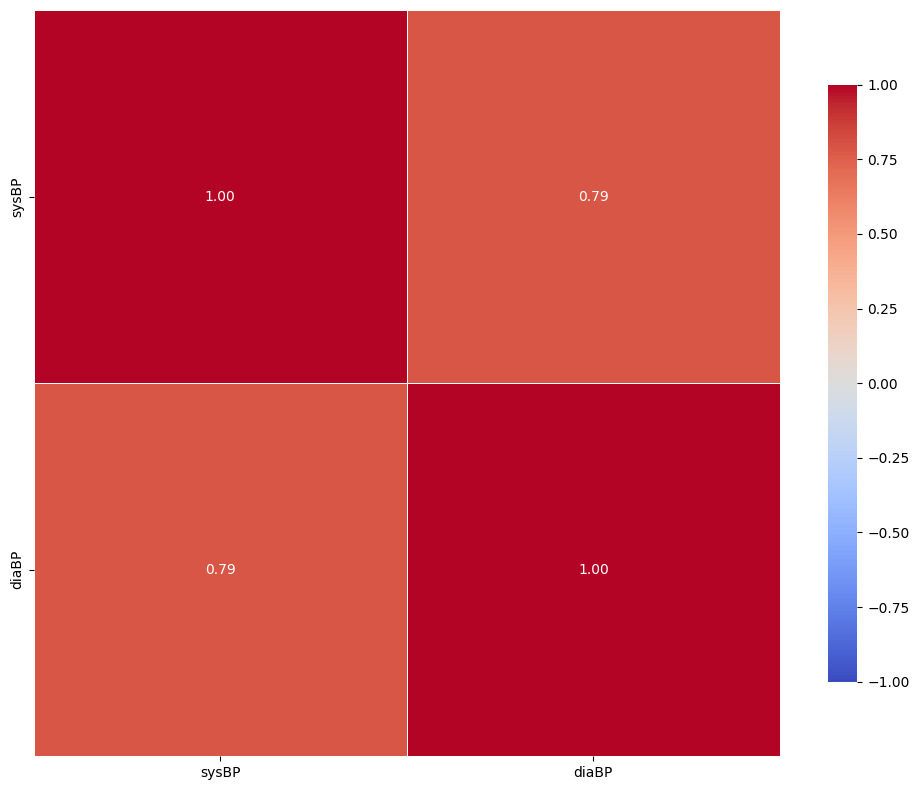

CORRELATION ANALYSIS: METABOLIC
Variables analyzed: 3

Correlation Matrix:


,totChol,glucose,BMI
totChol,1.000,0.045,0.115
glucose,0.045,1.000,0.081
BMI,0.115,0.081,1.000


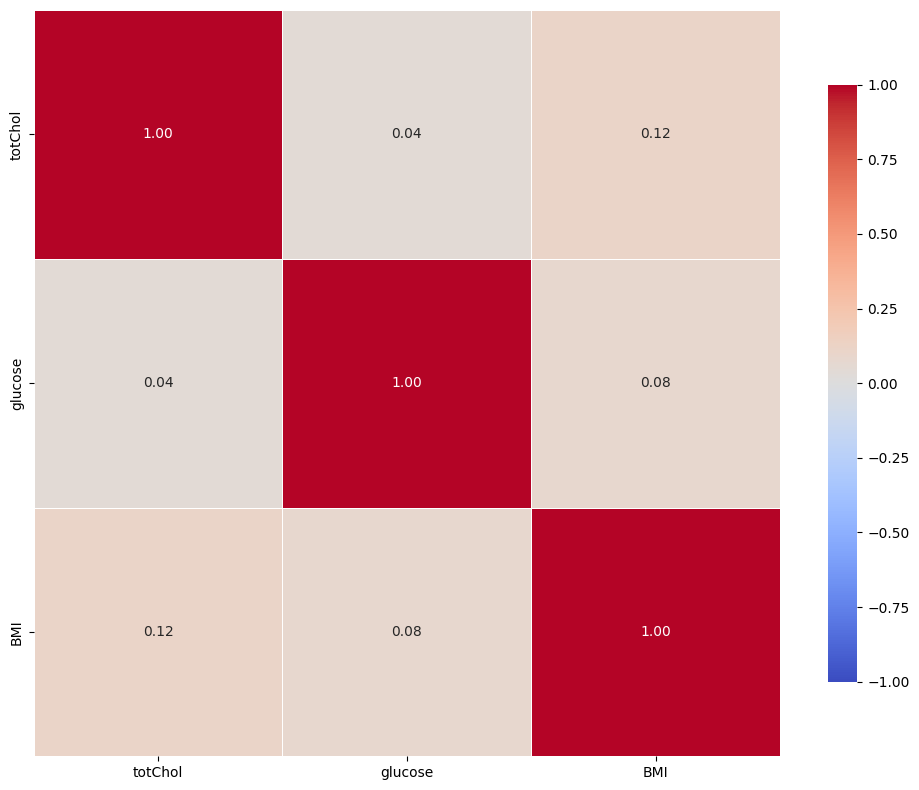

CORRELATION ANALYSIS: LIFESTYLE
Variables analyzed: 3

Correlation Matrix:


,cigsPerDay,BMI,age
cigsPerDay,1.000,-0.092,-0.193
BMI,-0.092,1.000,0.136
age,-0.193,0.136,1.000


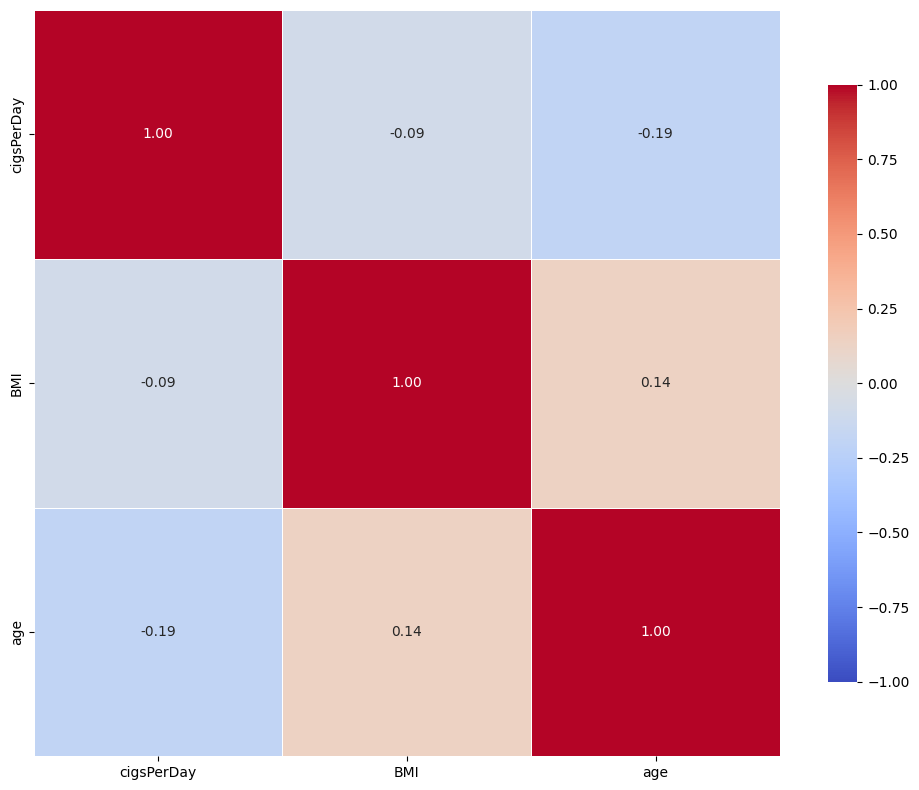

In [29]:
# Store correlation matrices for each group
correlation_results = {}

for group_name, group_info in available_groups.items():
    print(f"CORRELATION ANALYSIS: {group_name.upper()}")
    print(f"Variables analyzed: {len(group_info['variables'])}")
    
    # Calculate correlation matrix
    corr_matrix = df_normalized[group_info['variables']].corr()
    correlation_results[group_name] = corr_matrix
    
    # Display correlation matrix
    print(f"\nCorrelation Matrix:")
    display(corr_matrix.round(3))
    
    # Visualize correlation matrix (only for manageable sizes)
    if len(group_info['variables']) <= 15:
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, 
                    annot=True, 
                    fmt='.2f', 
                    cmap='coolwarm', 
                    center=0,
                    square=True,
                    linewidths=0.5,
                    cbar_kws={"shrink": 0.8},
                    vmin=-1, vmax=1) 
        plt.tight_layout()
        plt.show()
    else:
        print(f"  (Skipping visualization - too many variables: {len(group_info['variables'])})")

## 7. Identify High Correlations in Each Group
Now we find highly correlated variable pairs in each group by putting the threshold at 0.7

In [30]:
# Function to find highly correlated variable pairs
def find_high_correlations(corr_matrix, threshold=0.7):
    # Get upper triangle of correlation matrix to avoid duplicates
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find pairs with correlation > threshold
    high_corr_pairs = []
    for column in upper_triangle.columns:
        for index in upper_triangle.index:
            corr_value = upper_triangle.loc[index, column]
            if abs(corr_value) > threshold:
                high_corr_pairs.append({
                    'Variable 1': index,
                    'Variable 2': column,
                    'Correlation': corr_value
                })
    
    # Return empty DataFrame with correct columns if no pairs found
    if len(high_corr_pairs) == 0:
        return pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Correlation'])
    
    return pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                      key=abs, 
                                                      ascending=False)

# Find high correlations in each group
high_corr_summary = {}

for group_name, corr_matrix in correlation_results.items():
    print(f"HIGH CORRELATIONS: {group_name.upper()}")
    
    # Try threshold 0.6 first
    high_corr_df = find_high_correlations(corr_matrix, threshold=0.7)
    
    if len(high_corr_df) > 0:
        print(f"\nHighly Correlated Pairs (|r| > 0.7): {len(high_corr_df)}")
        display(high_corr_df)
        high_corr_summary[group_name] = {'threshold': 0.7, 'pairs': len(high_corr_df)}
    else:
        print("\nNo pairs found with |r| > 0.7")
        print("Checking with threshold |r| > 0.6...")
        high_corr_df = find_high_correlations(corr_matrix, threshold=0.6)
        if len(high_corr_df) > 0:
            display(high_corr_df)
            high_corr_summary[group_name] = {'threshold': 0.6, 'pairs': len(high_corr_df)}
        else:
            print("No pairs found with |r| > 0.6")
            print("✓ All variables in this group are sufficiently independent")
            high_corr_summary[group_name] = {'threshold': 0.6, 'pairs': 0}

HIGH CORRELATIONS: BLOOD PRESSURE

Highly Correlated Pairs (|r| > 0.7): 1


,Variable 1,Variable 2,Correlation
0,sysBP,diaBP,0.785519


HIGH CORRELATIONS: METABOLIC

No pairs found with |r| > 0.7
Checking with threshold |r| > 0.6...
No pairs found with |r| > 0.6
✓ All variables in this group are sufficiently independent
HIGH CORRELATIONS: LIFESTYLE

No pairs found with |r| > 0.7
Checking with threshold |r| > 0.6...
No pairs found with |r| > 0.6
✓ All variables in this group are sufficiently independent


## 8. Variable Selection Strategy
Now we want to select the representative variables after the correlation analysis by removing the highly correlated ones. And for each pair of highly correlated variables, we keep the one with lower average correlation with other variables.

In [31]:
def select_representative_variables(corr_matrix, threshold=0.6):

    avg_corr = corr_matrix.abs().mean().sort_values(ascending=True)
    variables_to_remove = set()
    
    # Get upper triangle to avoid duplicates
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # For each highly correlated pair, remove the one with higher avg correlation
    for column in upper_triangle.columns:
        for index in upper_triangle.index:
            corr_value = upper_triangle.loc[index, column]
            if abs(corr_value) > threshold:
                if avg_corr[index] > avg_corr[column]:
                    variables_to_remove.add(index)
                else:
                    variables_to_remove.add(column)
    
    variables_to_keep = set(corr_matrix.columns) - variables_to_remove
    return sorted(list(variables_to_keep)), sorted(list(variables_to_remove))

print("VARIABLE SELECTION")


# Track variables to remove across all groups
all_vars_to_remove = set()

# Apply selection to each group
for group_name, corr_matrix in correlation_results.items():
    threshold = high_corr_summary[group_name]['threshold']
    
    if high_corr_summary[group_name]['pairs'] > 0:
        vars_to_keep, vars_to_remove = select_representative_variables(corr_matrix, threshold)
        all_vars_to_remove.update(vars_to_remove)
        
        print(f"\n{group_name}:")
        print(f"  ✗ Remove: {vars_to_remove}")
        print(f"  ✓ Keep: {vars_to_keep}")

# Get all continuous variables analyzed
all_analyzed_vars = set()
for group_info in available_groups.values():
    all_analyzed_vars.update(group_info['variables'])

# Final lists
vars_to_remove = sorted(list(all_vars_to_remove))
vars_to_keep = sorted(list(all_analyzed_vars - all_vars_to_remove))

# Add variables not in any group
vars_not_in_groups = set(numeric_cols) - all_analyzed_vars
if vars_not_in_groups:
    vars_to_keep.extend(sorted(list(vars_not_in_groups)))

print("FINAL RESULTS")
print(f"Total continuous variables: {len(numeric_cols)}")
print(f"Removed: {len(vars_to_remove)} - {vars_to_remove if vars_to_remove else 'None'}")
print(f"Kept: {len(vars_to_keep)}")
print(f"{'='*70}")

VARIABLE SELECTION

Blood Pressure:
  ✗ Remove: ['diaBP']
  ✓ Keep: ['sysBP']
FINAL RESULTS
Total continuous variables: 8
Removed: 1 - ['diaBP']
Kept: 7


We chose this approach so that it captures correlations across the entire dataset, and provides comprehensive dimensionality reduction, and removes redundancy while preserving distinct medical information.


## 9. Create Cleaned DataFrame

In [32]:
# Get all columns to keep (non-numeric + selected numeric variables)
non_numeric_cols = [col for col in df_normalized.columns if col not in numeric_cols]
all_cols_to_keep = non_numeric_cols + vars_to_keep

# Create cleaned dataframe
cleaned_df = df_normalized[all_cols_to_keep].copy()

print(f"Original shape: {df_normalized.shape}")
print(f"Cleaned shape: {cleaned_df.shape}")
print(f"Removed {len(vars_to_remove)} redundant variable(s)")

# Display first few rows
display(cleaned_df.head())

Original shape: (4218, 15)
Cleaned shape: (4218, 14)
Removed 1 redundant variable(s)


,sex,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes,TenYearCHD,BMI,age,cigsPerDay,glucose,sysBP,totChol,heartRate
0,1,0,0,0,0,0,0,0.277024,0.184211,0.000000,0.104520,0.106383,0.140652,0.363636
1,0,0,0,0,0,0,0,0.319680,0.368421,0.000000,0.101695,0.177305,0.234991,0.515152
2,1,1,0,0,0,0,0,0.237518,0.421053,0.285714,0.084746,0.208038,0.226415,0.313131
3,0,1,0,0,1,0,1,0.316045,0.763158,0.428571,0.177966,0.314421,0.192110,0.212121
4,0,1,0,0,0,0,0,0.183228,0.368421,0.328571,0.127119,0.219858,0.295026,0.414141


## 10.  Export Files

In [33]:
# Save cleaned dataframe
cleaned_df.to_csv('../data/03_processed/processed_dataframe.csv', index=False)